# Helpfulness Prediction
## Data Science and Big Data Analytics Project

---

### Authors: 
- **Andrea Alberti** ([GitHub](https://github.com/AndreaAlberti07))
- **Davide Ligari** ([GitHub](https://github.com/DavideLigari01))
- **Cristian Andreoli** ([GitHub](https://github.com/CristianAndreoli94))

### Date: September 2023

---

## Data: 
The chosen dataset is [Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews).


## Goal:
Build a model able to predict the helpfulness of a review based on its content. 

---

In [1]:
import pymongo as pm
import pyspark as ps
import pandas as pd
import numpy as np
import gensim
import sklearn as sk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Load all the needed data

In [18]:
# Load the embeddings
train_data = np.load('../model/_gitignore/train_data_wv2_30_5.npz', allow_pickle=True)
test_data = np.load('../model/_gitignore/test_data_w2v_30_5.npz', allow_pickle=True)

# Split the data into X and Y
X_train = train_data['x']
Y_train = train_data['y']
X_test = test_data['x']
Y_test = test_data['y']

# Load the model
rand_forest = joblib.load('../model/_gitignore/rand_forest_model_md30_mss4_ne100.gz')

# Predict on the data
Y_test_pred = rand_forest.predict(X_test)
Y_train_pred = rand_forest.predict(X_train)

def rmse(Y_test, Y_pred):
    return np.sqrt(sk.metrics.mean_squared_error(Y_test, Y_pred))

### 2. Predict and Analyze

#### - **rmse**


In [19]:
# Calculate the RMSE
train_rmse = rmse(Y_train, Y_train_pred)
test_rmse = rmse(Y_test, Y_test_pred)

print('RMSE on train data: ', train_rmse)
print('RMSE on test data: ', test_rmse)

RMSE on train data:  0.07025060795837805
RMSE on test data:  0.15582059391833675


#### - **translate the helpfulness score in number of votes**:
The plot shows the couple (n_is_helpful, n_votes) leading to a helpfulness score of ~0.8. Moreover it shows the upper and lower bound of the helpfulness score, respectively adding and subtracting the root mean square error to the helpfulness score.  


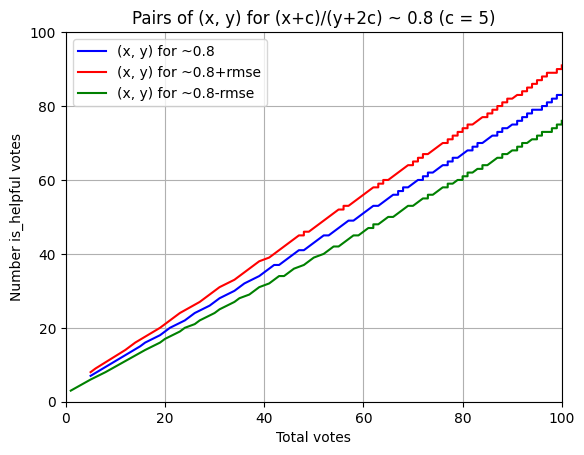

In [3]:
def equation(c, x, y):
    return (x + c) / (y + 2 * c)

def find_xy_pairs(c, target_ratio, rmse, max_value=100):
    valid_pairs = []
    upper_pairs = []
    lower_pairs = []

    for x in range(1, max_value + 1):
        for y in range(1, max_value + 1):
            if (
                equation(c, x, y) >= target_ratio * 0.99
                and equation(c, x, y) <= target_ratio * 1.01
            ):
                valid_pairs.append((x, y))
            if (
                equation(c, x, y) >= (target_ratio+rmse) * 0.99
                and equation(c, x, y) <= (target_ratio+rmse) * 1.01
            ):
                upper_pairs.append((x, y))
            if (
                equation(c, x, y) >= (target_ratio-rmse) * 0.99
                and equation(c, x, y) <= (target_ratio-rmse) * 1.01
            ):
                lower_pairs.append((x, y))

    return valid_pairs, upper_pairs, lower_pairs

c = 5  # Replace with your desired constant value
target_ratio = 0.8  # Replace with your desired target ratio
max_value = 100  # You can adjust this maximum value as needed

valid_pairs, upper_pairs, lower_pairs = find_xy_pairs(c, target_ratio, train_rmse, max_value)

x_values_valid = [x for x, _ in valid_pairs]
y_values_valid = [y for _, y in valid_pairs]
x_values_upper = [x for x, _ in upper_pairs]
y_values_upper = [y for _, y in upper_pairs]
x_values_lower = [x for x, _ in lower_pairs]
y_values_lower = [y for _, y in lower_pairs]

plt.plot(y_values_valid, x_values_valid, label=f"(x, y) for ~{target_ratio}", color='blue')
plt.plot(y_values_upper, x_values_upper, label=f"(x, y) for ~{target_ratio}+rmse", color='red')
plt.plot(y_values_lower, x_values_lower, label=f"(x, y) for ~{target_ratio}-rmse", color='green')
plt.ylim(0, max_value)
plt.xlim(0, max_value)
plt.xlabel("Total votes")
plt.ylabel("Number is_helpful votes")
plt.title(f"Pairs of (x, y) for (x+c)/(y+2c) ~ {target_ratio} (c = {c})")
plt.grid(True)
plt.legend()
plt.show()



#### - **retrieve words leading to higher improvement in the prediction**


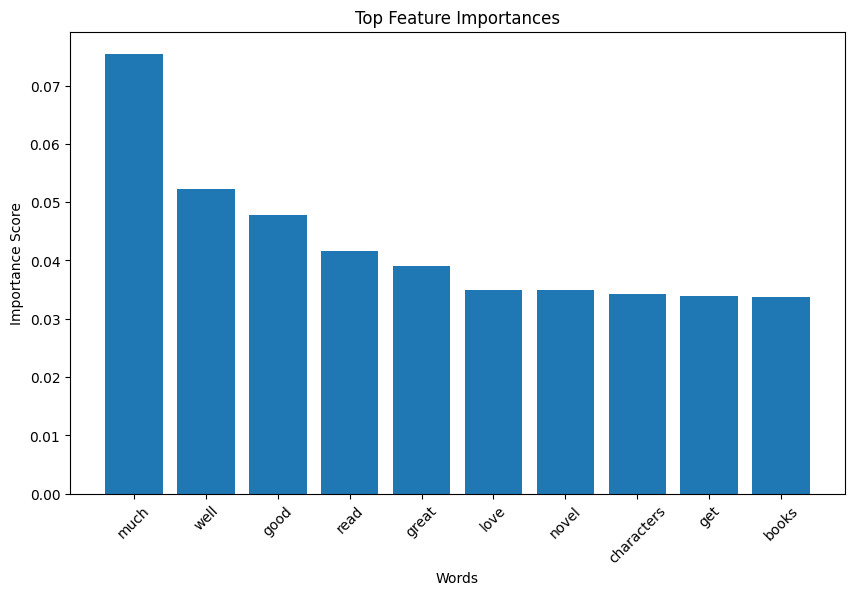

In [4]:
# Load the model Word2Vec model
model = gensim.models.Word2Vec.load('../model/_gitignore/word2vec.model')

# Get the feature importances from the trained model
feature_importances = rand_forest.feature_importances_

# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Get the top N most important words
top_N = 10  # Change this to the desired number of top words
top_words = [model.wv.index_to_key[idx] for idx in sorted_idx[:top_N]]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(top_N), feature_importances[sorted_idx[:top_N]])
plt.xticks(range(top_N), top_words, rotation=45)
plt.title("Top Feature Importances")
plt.xlabel("Words")
plt.ylabel("Importance Score")
plt.show()


#### - **partial dependence plot**


/Users/andreaalberti/micromamba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


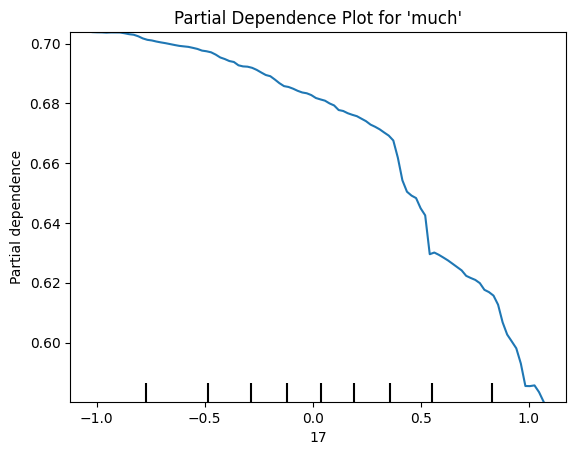

In [5]:
from sklearn.inspection import plot_partial_dependence

# Assuming 'X' is your feature matrix (Word2Vec representation)
# and 'rf_model' is your trained Random Forest model
word_idx = model.wv.key_to_index['much']

# Create a PDP for the specific word
plot_partial_dependence(rand_forest, X_train, features=[word_idx], grid_resolution=100)
plt.title("Partial Dependence Plot for 'much'")
plt.show()


#### - **analyze the error distribution**

In [20]:
import pymongo as pm
import pandas as pd
from seaborn import heatmap
import sklearn as sk
import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

client = pm.MongoClient('mongodb://localhost:27017/')
spark_db = client['spark_db']
books_ratings = spark_db['books_rating']

smoothing_param = 1
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
    
                }

pipeline_project = {'$project':{
                            'review/text':1,
                            'N_helpful':1,
                            'Tot_votes':1,
                            'helpfulness_score':{'$divide':[
                                                        {'$sum':['$N_helpful', smoothing_param]},
                                                        {'$sum': ['$Tot_votes', smoothing_param*2]}
                                                             ]
                                                 },
                            '_id':0,
                            }
                    }

mongo_dataset = books_ratings.aggregate([pipeline_remove, pipeline_project])
df_dataset = pd.DataFrame(list(mongo_dataset))
arr_dataset = np.array(df_dataset)

X_train_all, X_test_all, Y_train_all, Y_test_all = sk.model_selection.train_test_split(arr_dataset[:,0:3], arr_dataset[:,3], test_size=0.2, random_state=42)


stop_words = set(stopwords.words('english'))

model = gensim.models.Word2Vec.load("../model/_gitignore/word2vec.model")

def preprocess(doc):
    tokens = gensim.utils.simple_preprocess(doc)
    return [token for token in tokens if token not in stop_words]

def get_embedding(doc):
    embeddings = []
    words = preprocess(doc)
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

X_test_embedding = [get_embedding(doc) for doc in X_test_all[:,0]]


Y_test_pred = rand_forest.predict(X_test_embedding)
Y_test_pred_error = Y_test_pred - Y_test_all

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
print(max(X_test_all[:,1]))
print(max(X_test_all[:,2]))

10855
11262


0.20993655537483857

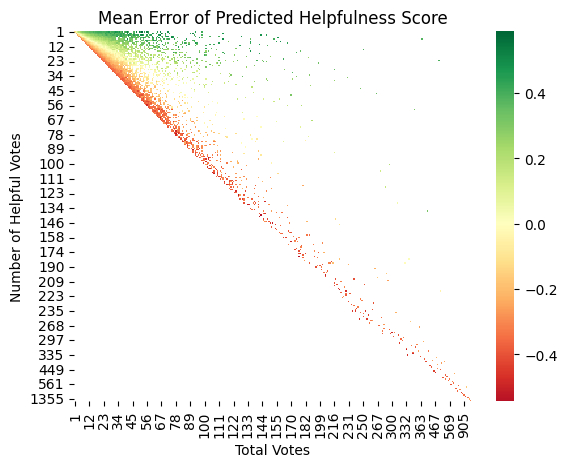

In [22]:
data = {'N_helpful':X_test_all[:,1], 'Tot_votes':X_test_all[:,2], 'Y_error':Y_test_pred_error}
df = pd.DataFrame(data)
df_pivot = df.pivot_table(index = 'N_helpful', columns = 'Tot_votes', values = 'Y_error', aggfunc = 'mean')
heatmap(df_pivot, cmap = 'RdYlGn', center = 0)
plt.title('Mean Error of Predicted Helpfulness Score')
plt.xlabel('Total Votes')
plt.ylabel('Number of Helpful Votes')

rmse(Y_test_all, Y_test_pred)

<AxesSubplot: title={'center': 'Mean Error of Predicted Helpfulness Score'}, xlabel='Total Votes', ylabel='Mean Error'>

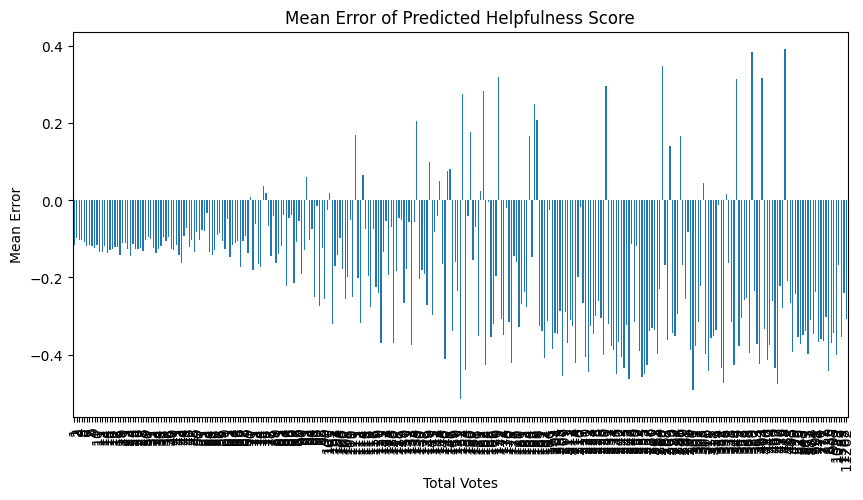

In [14]:
df.groupby('Tot_votes')['Y_error'].mean().plot(kind = 'bar',title = 'Mean Error of Predicted Helpfulness Score', xlabel = 'Total Votes', ylabel = 'Mean Error', figsize = (10,5))